In [1]:
import numpy as np
from collections import defaultdict
from scipy.linalg import orth
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from IPython.display import clear_output

%matplotlib inline 

In [2]:
class Manifold(object):
    
    def __init__(self, p, q):
        self.saved_UdU_T = defaultdict()
        self.p = p
        self.q = q

    
    def generate_equation(self, x, index):
        try: 
            UdU_T = self.saved_UdU_T[index]
        except KeyError:
            d = np.diag(np.random.uniform(-1, 1,  self.q))
            U = orth(np.random.normal(0, 1, (self.q, self.q)))
            UdU_T = U.dot(d).dot(U.T)
            self.saved_UdU_T[index] = UdU_T
        return x.T.dot(UdU_T).dot(x)
    
    

def generate_sample(x_0, p, q, N, manifold, eps):
    generated_sample = []
    for n in range(N):
        x = np.zeros(p)
        for i in range(q):
            x[i] = np.random.uniform(x_0[i] - eps, x_0[i] + eps)
        for j in range(q, p):
            x[j] = manifold.generate_equation(x[:q], j)
        generated_sample.append(x)
    return np.array(generated_sample)


class Function(object):
    
    def __init__(self, q):
        self.q = q

    def func(self, x):
        result = 0
        for i in range(q):
            if i % 2:
                result += np.exp(x[i]) * (i + 1)
            else:
                result += np.sin(x[i]) * (i + 1)
        return result

    def grad(self, x):
        result = np.zeros(q)
        for i in range(self.q):
            if i % 2:
                result[i] = np.exp(x[i]) * (i + 1)
            else:
                result[i] = np.cos(x[i]) * (i + 1)
        return result


def find_real_grad_V(real_grad, V):
    real_grad_V = []
    for v in V:
        real_grad_v = 0
        for i, grad in enumerate(real_grad):
            real_grad_v += v[i] * grad
        real_grad_V.append(real_grad_v)
    return np.array(real_grad_V)
            
    
def find_error(p, q, N, eps, x_0, manifold):
    f = Function(q)
    X = generate_sample(x_0, p, q, N, manifold, eps)
    pca = PCA(n_components = q)
    W = pca.fit_transform(X)
    V = pca.components_  


    b = np.array([f.func(x) - f.func(x_0) for x in X]).T

    estimated_grad = np.linalg.lstsq(W,  b)[0]
    
    real_grad = find_real_grad_V(f.grad(x_0), V)

    error = np.linalg.norm(estimated_grad - real_grad)
    return error


In [3]:
def find_coefficients(parameters, values):
    parameters = np.log2(parameters)
    values = np.log2(values)

    X = np.vstack((np.ones(np.shape(parameters)), parameters)).transpose()

    # Create linear regression object
    model = linear_model.LinearRegression(fit_intercept = False)

    # Train the model using the training sets
    model.fit(X, values)
    
    # The coefficients
    print('Coefficients: \n', model.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((model.predict(X) - values) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % model.score(X, values))

# Зависимость ошибки от эпсилон

In [4]:
p = 3
q = 2
N = 3
manifold = Manifold(p, q)
x_0 = np.zeros(p)

In [5]:

errors_eps = []
epsilons = []
std_eps = []

for i in range(1, 20):
    eps = np.power(2., -i)
    clear_output()
    print(i)

    temp_errors = []
    for j in range(1000):
        error = find_error(p, q, N, eps, x_0, manifold)
        temp_errors.append(error)
    epsilons.append(eps)
    errors_eps.append(np.mean(temp_errors))
    std_eps.append(np.sqrt(np.var(temp_errors)))

epsilons = np.array(epsilons)
errors_eps = np.array(errors_eps)
std_eps = np.array(std_eps)

19


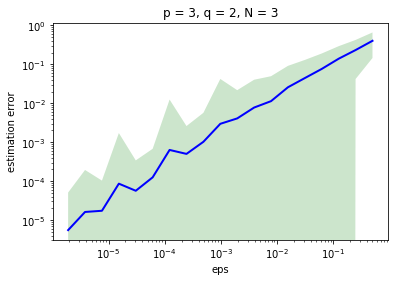

In [6]:
plt.plot(epsilons,errors_eps, linewidth=2.0, ms=12.0, 
         alpha=1.0, c='b')
plt.fill_between(epsilons, errors_eps + std_eps, errors_eps - std_eps , alpha = 0.2, facecolor='green')

plt.title('p = 3, q = 2, N = 3')
plt.xlabel('eps')
plt.ylabel('estimation error')
plt.xscale('log')
plt.yscale('log')

In [8]:
find_coefficients(epsilons,errors_eps)

Coefficients: 
 [ 0.44401236  0.95274136]
Mean squared error: 0.12
Variance score: 1.00


/Users/illarionPetrov/anaconda2/envs/py3k/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


# Зависимость ошибки от N

In [27]:
p = 3
q = 2
eps = 1e-2
manifold = Manifold(p, q)
x_0 = np.zeros(p)

In [28]:
errors_N = []
N_array = []
std_N = []

for i in range(10):
    N = 10 * np.power(2, i)
    clear_output()
    print(N)

    temp_errors = []
    for j in range(100):
        error = find_error(p, q, N, eps, x_0, manifold)
        temp_errors.append(error)
    N_array.append(N)
    errors_N.append(np.mean(temp_errors))
    std_N.append(np.sqrt(np.var(temp_errors)))

epsilons = np.array(epsilons)
errors_N = np.array(errors_N)
std_N = np.array(std_N)

5120


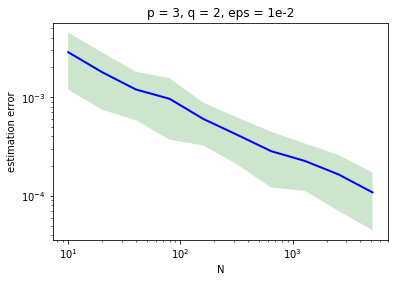

In [29]:
plt.plot(N_array, errors_N, linewidth=2.0, ms=12.0, 
         alpha=1.0, c='b')
plt.fill_between(N_array, errors_N + std_N, errors_N - std_N , alpha = 0.2, facecolor='green')

plt.title('p = 3, q = 2, eps = 1e-2')
plt.xlabel('N')
plt.ylabel('estimation error')
plt.yscale('log')
plt.xscale('log')

In [30]:
find_coefficients(N_array,errors_N)

Coefficients: 
 [-6.89047717 -0.51138758]
Mean squared error: 0.01
Variance score: 1.00


# Зависимость ошибки от q

In [13]:
p = 100
eps = 1e-2
N = 200

x_0 = np.zeros(p)

In [14]:
errors_q = []
q_array = []
std_q = []


for q in np.arange(2, 90):
    clear_output()
    print(q)
    manifold = Manifold(p, q)
#     eps = np.power(N, -1/(q+2))

    q_array.append(q)
    
    temp_errors = []
    for j in range(10):
        error = find_error(p, q, N, eps, x_0, manifold)
        temp_errors.append(error)
    errors_q.append(np.mean(temp_errors))
    std_q.append(np.sqrt(np.var(temp_errors)))

epsilons = np.array(epsilons)
errors_q = np.array(errors_q)
std_q = np.array(std_q)

89


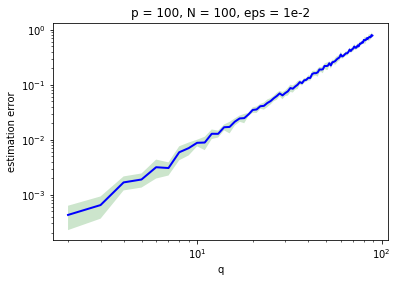

In [16]:
plt.plot( q_array , errors_q, linewidth=2.0, ms=12.0, 
         alpha=1.0, c='b')
plt.fill_between(q_array, errors_q + std_q, errors_q - std_q , alpha = 0.2, facecolor='green')

plt.title('p = 100, N = 100, eps = 1e-2')
plt.xlabel('q')
plt.ylabel('estimation error')
plt.xscale('log')
plt.yscale('log')

In [17]:
find_coefficients(q_array, errors_q)

Coefficients: 
 [-13.73333596   2.04986403]
Mean squared error: 0.01
Variance score: 1.00


# Зависимость ошибки от p

In [18]:
q = 5
eps = 1e-2
N = 100

x_0 = np.zeros(p)

In [19]:
errors_p = []
p_array = []
std_p = []

for p in np.arange(8, 1000, 20):
    clear_output()
    print(p)
    manifold = Manifold(p, q)
    p_array.append(p)
    
    temp_errors = []
    for j in range(10):
        error = find_error(p, q, N, eps, x_0, manifold)
        temp_errors.append(error)
    errors_p.append(np.mean(temp_errors))
    std_p.append(np.sqrt(np.var(temp_errors)))

epsilons = np.array(epsilons)
errors_p = np.array(errors_p)
std_p = np.array(std_p)


988


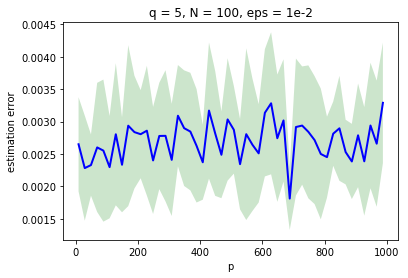

In [20]:
plt.plot(p_array, errors_p, linewidth=2.0, ms=12.0, 
         alpha=1.0, c='b')
plt.fill_between(p_array, errors_p + std_p, errors_p - std_p, alpha = 0.2, facecolor='green')

plt.title('q = 5, N = 100, eps = 1e-2')
plt.xlabel('p')
plt.ylabel('estimation error')


In [21]:
find_coefficients(p_array, errors_p)

Coefficients: 
 [-8.75135252  0.02485033]
Mean squared error: 0.02
Variance score: 0.05
